# Test notebook

This notebook is only for testing map calculations.

We first gonna load the datasets (train, cfips_coordinates)

In [2]:
import pandas as pd
import numpy as np
import math

# dfc is a csv with 3 columns: fips, lat, lon (int, float, float)
dfc = pd.read_csv('io/customdata/cfips_coordinates.csv')
# dft is train data
dft = pd.read_csv('io/dataset/train.csv')

cfips = dft['cfips'].unique()
mbds = ()
coordinates = ()



Lets augment the dataset with x and y coordinates.

* Latitude is the y coordinate (-90 to 90)
* Longitude is the x coordinate (-180 to 180)

We will interpolate this data to get

* x (longitude 0 to 360)
* y (latitude 0 to 180)

In [3]:
# TODO: THIS COULD BE DONE WHEN DOWNLOADING THE DATASET

min(dfc['lat']), max(dfc['lat'])
min(dfc['lon']), max(dfc['lon'])
min_lat, max_lat = -90, 90
min_lon, max_lon = -180, 180
min_x, max_x = 0, 360
# min_x, max_x = 0, 280
min_y, max_y = 0, 180
# min_y, max_y = 0, 200
dfc['x'] = np.interp(dfc['lon'], (min_lon, max_lon), (min_x, max_x))
dfc['y'] = np.interp(dfc['lat'], (min_lat, max_lat), (min_y, max_y))

dfc.head()

cfips        lat        lon          x           y
0   1001  32.508438 -86.658643  93.341357  122.508438
1   1009  33.950498 -86.634968  93.365032  123.950498
2   1017  32.892438 -85.264489  94.735511  122.892438
3   1021  32.840318 -86.697518  93.302482  122.840318
4   1033  34.712311 -87.873360  92.126640  124.712311

Now let's visualize this x, y coordinates

In [4]:
# visualize a scatter with x, y coordinate points using plotly.express
import plotly.express as px
fig = px.scatter(dfc, x="x", y="y", color="cfips", title="x,y coordinates map colored by cfips")
# set xaxis and yaxis ranges
fig.update_xaxes(range=[0, 360])
fig.update_yaxes(range=[0, 180])
fig.show()

OK, we have the approximate coordinates for each county.

Let's see how our train dataset looks like.

In [5]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


we will add the following columns to this train dataset:

* x
* y
* latitude
* longitude

In [6]:
for row in dfc.itertuples():
    if row.cfips in cfips:
        dft.loc[dft['cfips'] == row.cfips, 'x'] = row.x
        dft.loc[dft['cfips'] == row.cfips, 'y'] = row.y
        dft.loc[dft['cfips'] == row.cfips, 'latitude'] = row.lat
        dft.loc[dft['cfips'] == row.cfips, 'longitude'] = row.lon

dft.tail()

row_id  cfips         county    state first_day_of_month  \
122260  56045_2022-06-01  56045  Weston County  Wyoming         2022-06-01   
122261  56045_2022-07-01  56045  Weston County  Wyoming         2022-07-01   
122262  56045_2022-08-01  56045  Weston County  Wyoming         2022-08-01   
122263  56045_2022-09-01  56045  Weston County  Wyoming         2022-09-01   
122264  56045_2022-10-01  56045  Weston County  Wyoming         2022-10-01   

        microbusiness_density  active          x          y  latitude  \
122260               1.803249     101  75.764188  133.77916  43.77916   
122261               1.803249     101  75.764188  133.77916  43.77916   
122262               1.785395     100  75.764188  133.77916  43.77916   
122263               1.785395     100  75.764188  133.77916  43.77916   
122264               1.785395     100  75.764188  133.77916  43.77916   

         longitude  
122260 -104.235812  
122261 -104.235812  
122262 -104.235812  
122263 -104.235812  
122264 -104.235812

Ok, we have the columns we need to analyze the counties by their coordinates.

Do you remember the graph `x,y coordinates map colored by cfips` plotted above?

Let's now colorize this map based in the microbusiness density of each county instead of cfips.

In [29]:
dft_subset_date = dft.sort_values(by=['first_day_of_month'])['first_day_of_month'].iloc[0]
dft_subset = dft.query('first_day_of_month == @dft_subset_date')

fig = px.scatter(dft_subset, x="x", y="y", color="microbusiness_density", title="x,y coordinates map colored by cfips")
fig.show()

Notice that we have a lot of difference in the microbusiness density between of the counties, most of them are close to 0, but we have some counties with a very high microbusiness density.

Let's see how the distribution of microbusiness density looks like so we have a better idea why the map is so unicolor.

In [34]:
# see the distribution of microbusiness_density
# at the first date in the dataset

dft_subset_date = dft.sort_values(by=['first_day_of_month'])['first_day_of_month'].iloc[0]
dft_subset = dft.query('first_day_of_month == @dft_subset_date')

fig = px.histogram(dft_subset, x="microbusiness_density", title=f"microbusiness_density distribution at {dft_subset_date}")
fig.show()

I used the zoom feature from the above plot and tried to identify how we can group the counties based on their microbusiness density. I got 4 groups

* 0 - the counties whose density counts are growing to the top of the graph
* 1 - the counties whose density counts are decreasing fast
* 2 - the counties whose density is more stable
* 3 - the first half of the outliers
* 4 - the second half of the outliers

But we have an issue to deal with first. The density distribution may change it's shape according to the counties density variation. Let's see how is the distribution in the last first of the dataset.

In [45]:
# see the distribution of microbusiness_density
# at the last date in the dataset
import plotly.graph_objects as go

dft_subset_date_final = dft.sort_values(by=['first_day_of_month'])['first_day_of_month'].iloc[-1]
dft_subset_final = dft.query('first_day_of_month == @dft_subset_date_final')

fig_final = go.Figure(data=[go.Histogram(x=dft_subset_final['microbusiness_density'], opacity=1, name=dft_subset_date_final)])
fig_final.add_trace(go.Histogram(x=dft_subset['microbusiness_density'], opacity=0.3, name=dft_subset_date))
fig_final.update_layout(barmode='overlay')

fig_final.show()

This plot shows that we din't have so much variation in the groups, but if we zoom in, we can see that the distribution in 2022 has way more outliers.

In 2019 we had one county with a density approximate to 51, and one with density of approximate 278. Let's see the most dense counties back in 2019 and compare it to 2022.

In [52]:
print(f"most dense counties in {dft_subset_date}:")
dft_subset[['cfips','county','state','first_day_of_month','microbusiness_density']] \
  .sort_values(by=['microbusiness_density'], ascending=False) \
  .head()

most dense counties in 2019-08-01:


cfips           county         state first_day_of_month  \
94380   46127     Union County  South Dakota         2019-08-01   
87165   41061     Union County        Oregon         2019-08-01   
108966  49043    Summit County          Utah         2019-08-01   
72345   36061  New York County      New York         2019-08-01   
121992  56033  Sheridan County       Wyoming         2019-08-01   

        microbusiness_density  
94380              277.535980  
87165               50.874134  
108966              34.754463  
72345               32.904640  
121992              30.183279

In [53]:
print(f"most dense counties in {dft_subset_date_final}:")
dft_subset_final[['cfips','county','state','first_day_of_month','microbusiness_density']] \
  .sort_values(by=['microbusiness_density'], ascending=False) \
  .head(10)

most dense counties in 2022-10-01:


cfips               county           state first_day_of_month  \
122030  56033      Sheridan County         Wyoming         2022-10-01   
21839   16021      Boundary County           Idaho         2022-10-01   
11543    8105    Rio Grande County        Colorado         2022-10-01   
68366   32017       Lincoln County          Nevada         2022-10-01   
87203   41061         Union County          Oregon         2022-10-01   
12362   10005        Sussex County        Delaware         2022-10-01   
32681   19101     Jefferson County            Iowa         2022-10-01   
77024   37175  Transylvania County  North Carolina         2022-10-01   
109004  49043        Summit County            Utah         2022-10-01   
93911   46099     Minnehaha County    South Dakota         2022-10-01   

        microbusiness_density  
122030             227.756650  
21839               96.812622  
11543               93.466301  
68366               65.903671  
87203               61.287354  
12362               59.590317  
32681               47.399479  
77024               38.879021  
109004              37.714901  
93911               34.708752

In [7]:
for cfip in cfips:
    curr = dft[dft['cfips'] == cfip].tail(1)['microbusiness_density']
    mbds += (curr.tail(1).item(),)
    # lon, lat = dfc[dfc['cfips'] == cfip][['lon', 'lat']].to_numpy().flatten()
    x, y = dfc[dfc['cfips'] == cfip][['x', 'y']].to_numpy().flatten()
    coordinates += ((x, y),)
  #,
  #dfc[dfc['cfips']==row[0].astype(int)][['lat', 'lon']],
  #dft[dft['cfips']==row[0].astype(int)]['microbusiness_density'].tail(1).item(),
#))
assert len(cfips) == len(mbds) and len(mbds) == len(coordinates), f'cfips ({len(cfips)}), mbds ({len(mbds)}), and coordinates ({len(coordinates)}) are not the same length'
#print(cfips[0],mbds[0],coordinates[0])
# geodataset = (coordinates, mbds)
mbds_max = max(mbds)
mbds_min = min(mbds)
new_max = 4
new_min = 0
mbds_cat = np.interp(mbds, (mbds_min, mbds_max), (new_min, new_max))
#cfips, coordinates = dfc['cfips'], dfc[['lat', 'lon']].to_numpy()
#mbds = ()
#for cfip in cfips:
#    curr = dft[dft['cfips'] == cfip]['microbusiness_density']
#    if len(curr) > 0:
#      mbds += (curr.tail(1).item(),)
#assert len(mbds) == len(cfips), f'mbds ({len(mbds)}) and cfips ({len(cfips)}) are not the same length'
geodataset = (coordinates, mbds_cat)


/home/l/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


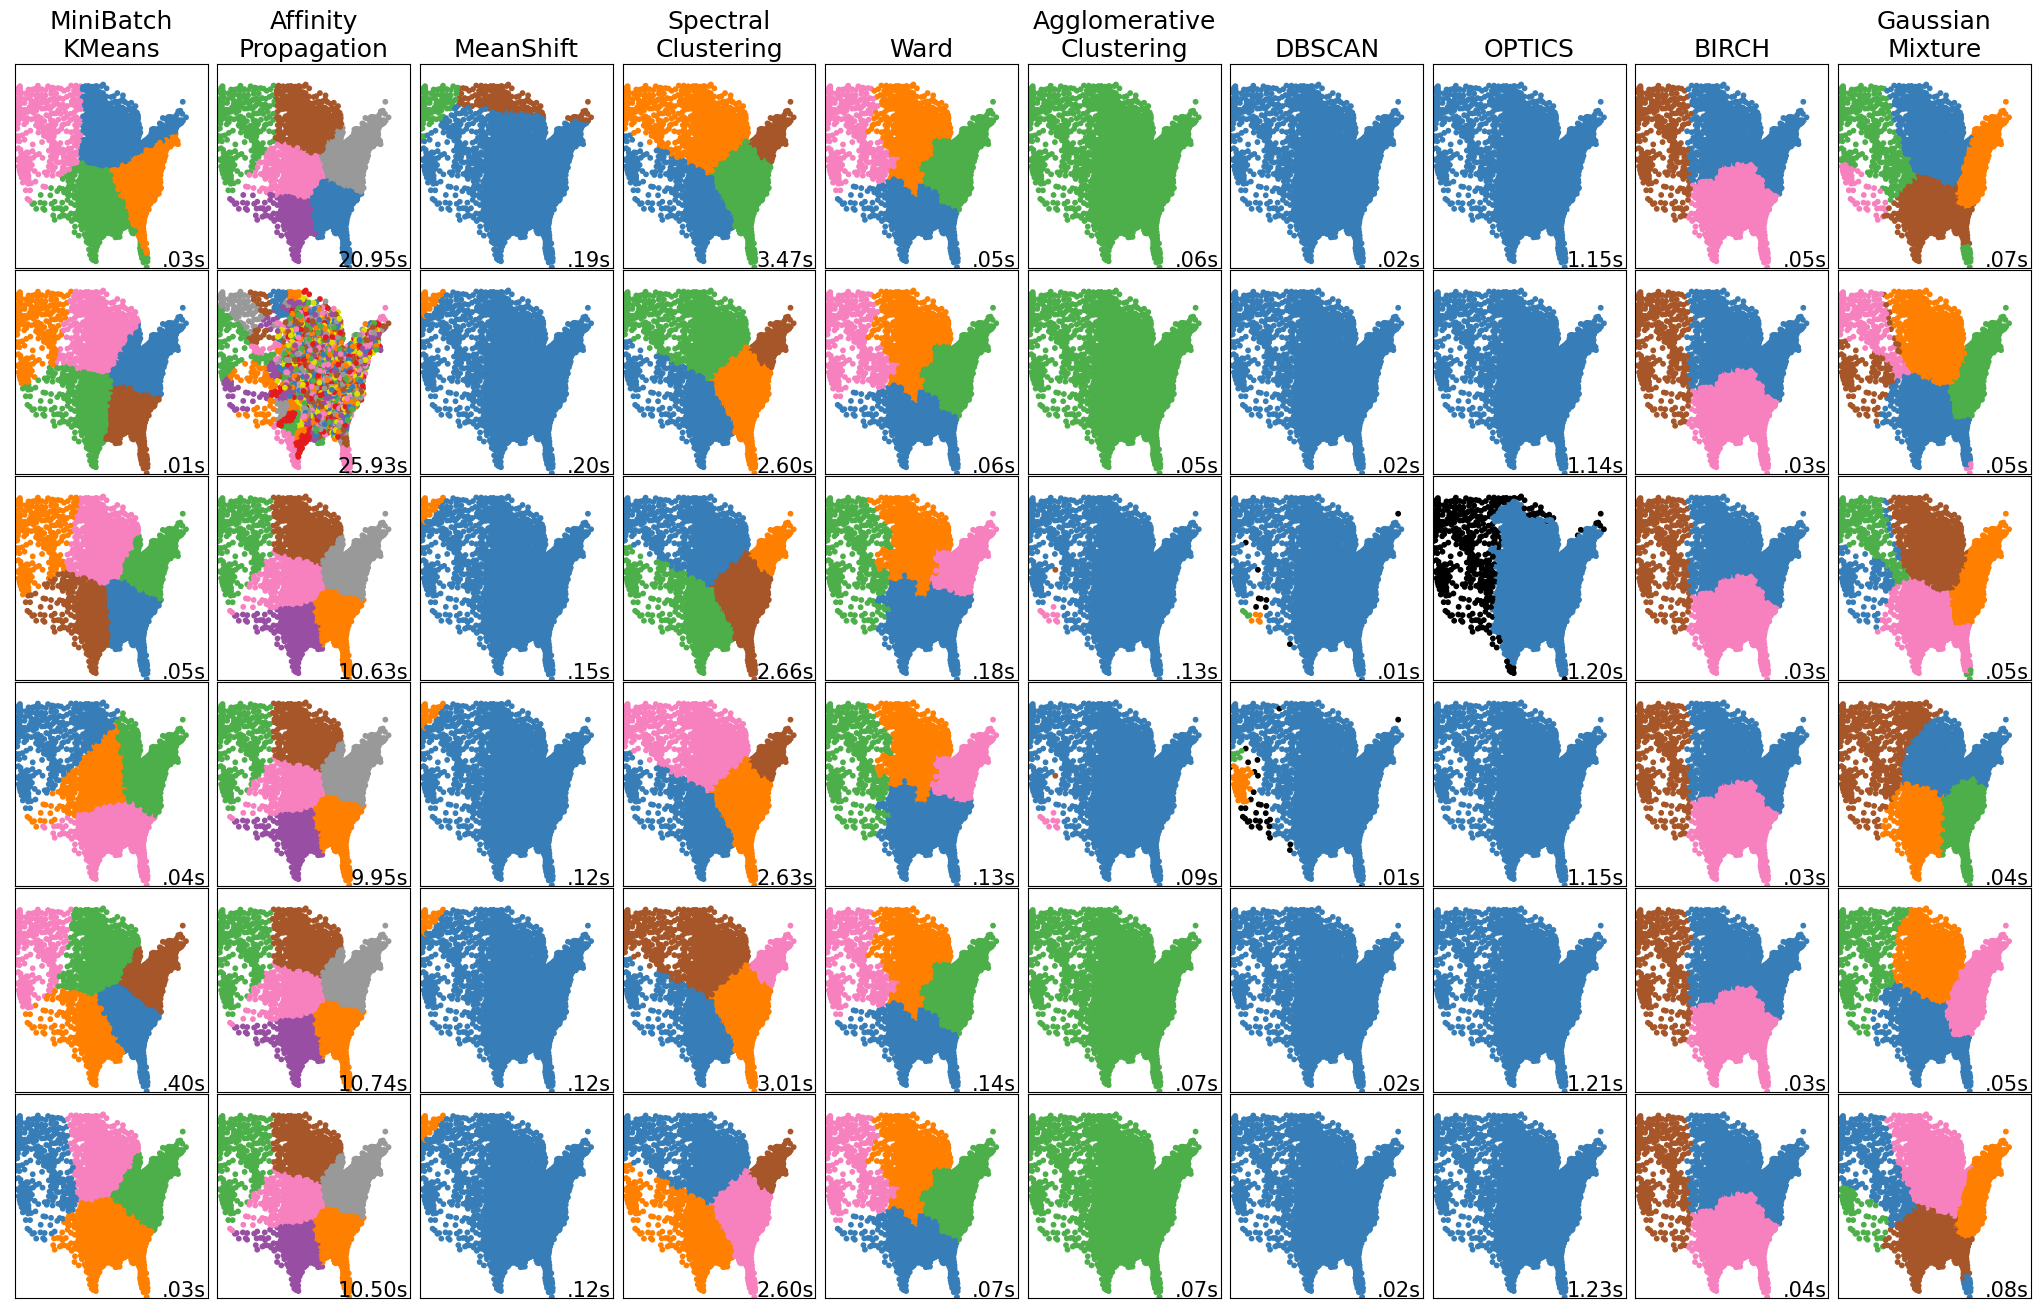

In [8]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 5,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    # noisy_circles,
    (
        geodataset,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 5,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    # noisy_moons
    (
        geodataset,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 5,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    # varied
    (
        geodataset,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    # aniso
    (
        geodataset,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    # (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (geodataset, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    # (no_structure, {}),
    (geodataset, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()